# Light transport simulation 

## Emission fields

The following algorithm computes the photon flux in the volume surrounding a light emitter. The result is a 3D array containing the probability of any emitted photon passing through that point per unit area (mm$^2$). 


Denote this probability as $q_e(\mathbf z)$. Note that this is not a probability density function. Rather, the integral $$\ell = \iiint_{\mathbf z \in \Omega} q_e(\mathbf z) d \mathbf z$$ evaluates the average travel length of an emitted photon within the integrated region $\Omega$.

## Detection fields 

Detection fields are computed using the same simulation by reversing the coordinate system. A single emitter is placed at the origin. The shape of the emitter now denotes the shape of the detector. However, the emission direction distribution is sperically symmetric. As simulated photon traverse space, they update the detection field according to the angular and positional sensitivity of the detector at that point.

The result is a 3D array containing the probability of a photon emitted at given point being detected by the detector. 

Denote this probability as $q_d(\mathbf z)$. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import tqdm

In [2]:
class Space:
    
    def __init__(self, pitch=2, dims=(300, 300, 300), 
                 emitter_shape="rect",
                 emitter_size=(10,10,0),
                 emission_spread="lambertian",
                 anisotropy=0.88, absorption_length=14000, scatter_length=100, 
                 beam_compression=1.0, beam_xy_aspect=1.0, y_steer=0.0, 
                 detector_type='total'):
        
        # irradiation field grid
        self.pitch = pitch   # (um) voxel pitch 
        self.dims = dims     # voxels
        self.emitter_shape = emitter_shape # e.g. rect or sphere
        self.emitter_size = emitter_size  # (um) (width, height, depth) (x, y, z)
        self.detector_type = detector_type
        
        # simulated photon packets: positions and directions
        self.n = 8192   # photon packets at a time
        self.start_positions = np.empty((self.n, 3))  # (um) x, y, z
        self.positions = np.empty((self.n, 3))   # (um)   x, y, z
        self.directions = np.empty((self.n, 3))  # (um)   x, y, z 
        
        # simulation parameters
        self.emission_spread = emission_spread
        self.mui = 1/absorption_length   # absorption rate: 1/um
        self.mue = 1/scatter_length   # scatter rate: 1/um
        self.mu = self.mui + self.mue  # total rate
        self.absorb_ratio = self.mui/self.mu  # probability of absoprtion at each hop
        self.anisotropy = anisotropy  # For the Henyey-Greenstein formula
        self.beam_compression = beam_compression
        self.beam_xy_aspect = beam_xy_aspect
        self.y_steer = y_steer  # (radians) steer angle        

        self.volume = np.zeros(self.dims) # x, y, z
        self.total_count = 0
        
    def emit(self, which):
        """
        :param which: indices of the photons to generate
        """
        # generate positions
        m = which.sum()
        if self.emitter_shape=="rect":
            positions = (np.random.rand(m, 3)-0.5) * self.emitter_size # intial position
        elif self.emitter_shape=="sphere":
            positions = np.random.randn(m, 3)
            positions *= 0.5*np.array(self.emitter_size)/np.sqrt((positions ** 2).sum(axis=1, keepdims=True))
        else:
            raise Exception('Invalid emitter shape')
        self.positions[which, :] = positions
            
        
        # generate directions
        if self.emission_spread == "parallel":
            directions = 0, 0, 1  # beam along z axis
        elif self.emission_spread == "spherical":
            directions = np.random.randn(m, 3) 
            directions /= np.sqrt((directions ** 2).sum(axis=1, keepdims=True))
        elif self.emission_spread == "lambertian":  # oriented along z-axis
            elev_sin = np.random.rand(m)**0.5   # sine of elevation
            azimuth = np.random.rand(m) * 2 * np.pi   
            azi_cos, azi_sin = np.cos(azimuth), np.sin(azimuth)
            
            # beam compression 
            if self.beam_compression != 1:
                elev_sin = np.sin(np.arcsin(elev_sin) * self.beam_compression)  # always positive
            if self.beam_xy_aspect != 1:
                azi_sin = np.arcsin(azi_sin) / self.beam_xy_aspect
                azi_cos = np.sign(azi_cos) * np.sqrt(1 - azi_sin*azi_sin)
            vx, vy, vz = elev_sin*azi_cos, elev_sin*azi_sin, np.sqrt(1-elev_sin*elev_sin)
            
            # beam steering around the x-axis
            if self.y_steer:
                steer_cos, steer_sin = np.cos(self.y_steer), np.sin(self.y_steer)
                vz, vy = steer_cos * vz - steer_sin * vy, steer_sin * vz + steer_cos * vy              
            directions = np.stack((vx, vy, vz)).T 
        else:
            raise Exception('invalid emission type')
        self.directions[which, :] = directions
            
        # retain photons' starting positions
        self.start_positions[which, :] = self.positions[which, :]
        
        
    def detector_sensitivity(self):
        """
        Detection selectivity based on incident angles self.directions and detector offsets self.detector_offsets
        """
        if self.detector_type == "total":  # use for emission field modeling
            return 1.0   
        if self.detector_type == "one-sided":  # equivalent to a lambertian emitter
            return np.maximum(0, np.sign(self.directions[:,2])) # along z-axis
        if self.detector_type == "narrowed":
            return np.maximum(0, self.directions[:,2])**4  # along z-axis
        raise Exception('Unknown detector type')
        
        
    def accumulate(self, start_points, end_points, lengths):
        """
        accumulate irradiation intensity between start_points and end_points
        """
        samples = 8   # points per hop  
        for i in range(samples):
            fractions = np.random.rand(self.n)[:, None]
            dims = np.array(self.dims)
            positions = np.round(dims/2 + 
                (start_points * fractions + end_points * (1 - fractions)) / self.pitch).astype(np.int32)
            keep = np.all(np.logical_and(positions >= 0, positions < dims), axis=1)
            positions = positions[keep, :]
            indices = np.ravel_multi_index((positions[:,0], positions[:,1], positions[:,2]), self.volume.shape)
            self.volume.ravel()[indices] += (self.detector_sensitivity() * lengths)[keep] / self.pitch / samples
            
        
    def hop(self):
        """
        execute photon hops between events, updating the irradition field
        """
        # irradiate
        lengths = np.random.exponential(1./self.mu, self.n) 
        new_positions = self.positions + lengths[:, None] * self.directions
        self.accumulate(self.positions, new_positions, lengths)
        self.positions = new_positions
        
        # absorb
        absorbed = np.random.rand(self.n) < self.absorb_ratio
        self.emit(absorbed)  # eliminate and absorb new ones
        self.total_count += absorbed.sum()
        
        # scatter: gcos follows the Henyey-Greenstein distribution of cosines
        scattered = np.logical_not(absorbed)
        m = scattered.sum()
        g = self.anisotropy
        gcos = 0.5 / g * (1 + g*g - ((1 - g*g)/(1 - g + 2*g * np.random.rand(m)))**2)
        gsin = np.sqrt(1-gcos*gcos)
        v = self.directions[scattered] * np.sign(gcos[:, None])
        d = np.random.randn(m, 3)*0.001
        d -= v * (v*d).sum(axis=1, keepdims=True)  # random orthogonal vector
        v += gsin[:,None] / np.sqrt((d**2).sum(axis=1, keepdims=True)) * d  # match length to gsin
        v /= np.sqrt((v**2).sum(axis=1, keepdims=True))  # normalize
        self.directions[scattered, :] = v
        
        
    def run(self, hops=100):
        self.emit(np.ones(self.n, dtype=np.bool))
        for _ in tqdm.tqdm(range(hops)):
            self.hop()
        # at the end, the values in volumes depict the photon flux per um^2 per emitted photons
        self.volume /= self.total_count
            
            
    def plot(self, axis=None, title="", gamma=0.5, cmap='gray'):
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((self.volume.sum(axis=0))**gamma, cmap=cmap)
        axis.axis(False)
        scale_bar = ScaleBar(self.pitch*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}: {space.total_count/1e6:0.2f} million simulated photons"
        axis.set_title(title)

# Emitter Tests

100%|██████████| 1000/1000 [00:06<00:00, 166.16it/s]


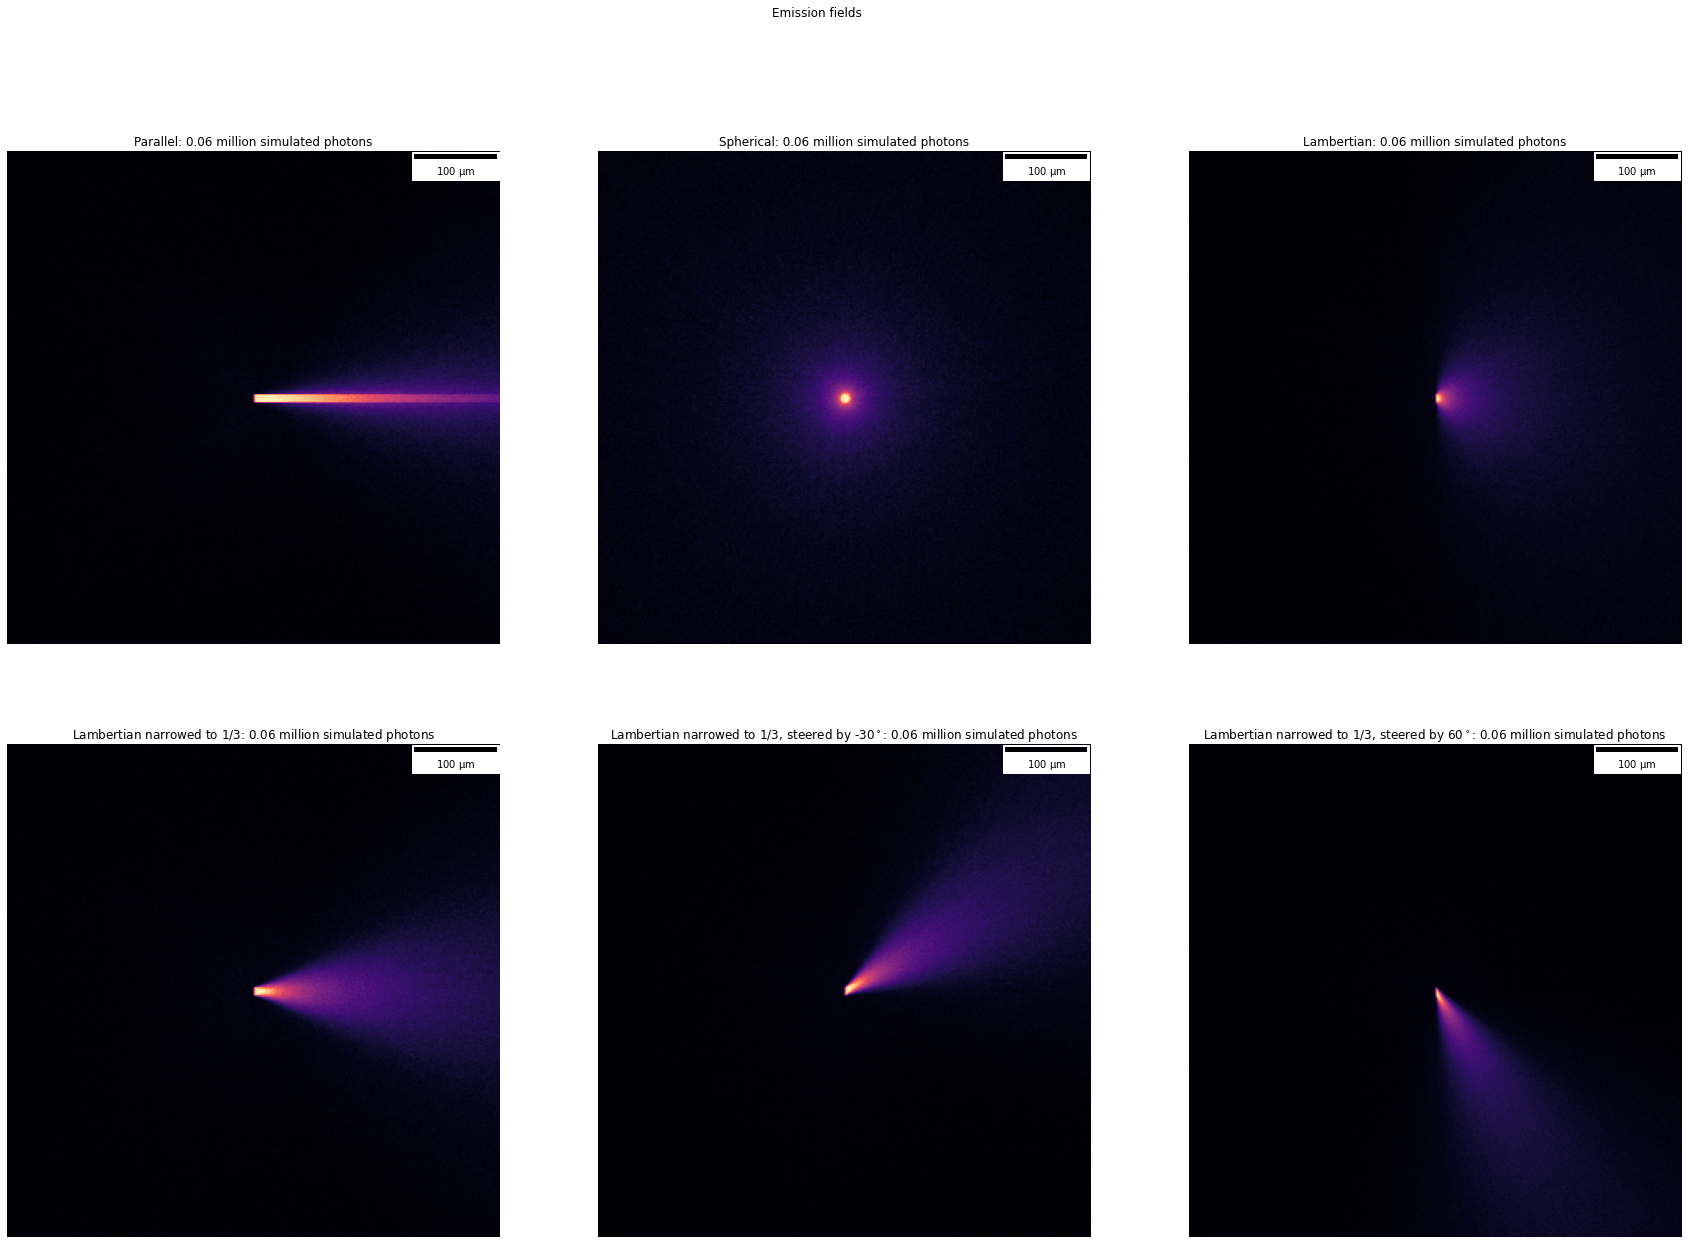

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax = iter(ax.flatten())

iterations = 1000
display_gamma = 0.7
cmap = 'magma'

fig.suptitle('Emission fields')

space = Space(emission_spread="parallel")
space.run(iterations)
space.plot(next(ax), "Parallel", gamma=display_gamma, cmap=cmap)

space = Space(emission_spread="spherical", emitter_shape="sphere", emitter_size=(10,10,10))
space.run(iterations)
space.plot(next(ax), "Spherical", gamma=display_gamma, cmap=cmap)

space = Space()
space.run(iterations)
space.plot(next(ax), "Lambertian", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3)
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $1/3$", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3, y_steer=-np.pi/6)
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $1/3$, steered by -$30^\circ$", gamma=display_gamma, cmap=cmap)

space = Space(beam_compression=1/3, y_steer=np.pi/3)
space.run(iterations)
space.plot(next(ax), "Lambertian narrowed to $1/3$, steered by $60^\circ$", gamma=display_gamma, cmap=cmap)



In [4]:
space.volume.sum()  # average distance traveled within the volume

250.7373957065858

100%|██████████| 1000/1000 [00:07<00:00, 135.56it/s]


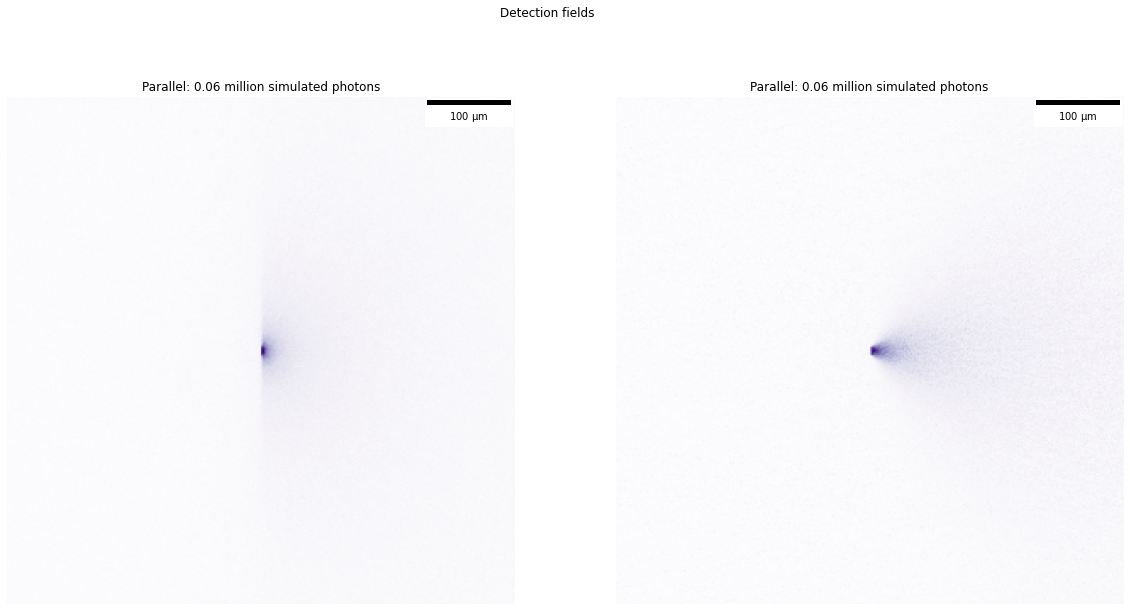

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = iter(ax.flatten())

fig.suptitle('Detection fields')

display_gamma = 0.7
iterations = 1000
cmap = 'Purples'

space = Space(detector_type="one-sided", emission_spread="spherical")
space.run(iterations)
space.plot(next(ax), "Parallel", gamma=display_gamma, cmap=cmap)

space = Space(detector_type="narrowed", emission_spread="spherical")
space.run(iterations)
space.plot(next(ax), "Parallel", gamma=display_gamma, cmap=cmap)